# Project 2: AI APPRAISER

Mengyu Jackson

## Overview

Our stakeholder is a mortgage lender who would like more accurate appraisals to reduce risk for home loans. We analyzed the King County (CA) House Sales dataset using machine learning to develop a model for predicting the value of a house. The model accurately predicts the value of a house with information available to the bank at time of appraisal, and would be a good tool for making loan decisions. We recommend using this model along with existing appraisers to reduce risk and increase profit margins.

## Business Problem

Our stakeholder is a mortgage lender who wants to increase the accuracy of their appraisals in order to reduce the risk of default, especially loans which have the minimum possible down payment (20%) without Private Mortgage Insurance. These loans are worth 80% of the purchase price of the house. If a borrower defaults immediately, our stakeholder wants confidence they'll be able to re-sell the house and cover the entire loan. At the same time, they do not want artificially low appraisals, as those would drive clients to competing lenders. Specifically, we want to maximize the number of appraisals which are between 80% and 105% of the true value of the house in order to minimize risk while remaining attractive to borrowers.


## Data Understanding

This project uses the King County House Sales dataset, which can be found in `kc_house_data.csv` in the data folder in this repo. The description of the column names can be found in `column_names.md` in the same folder. As with most real world data sets, the column names are not perfectly described, so you'll have to do some research or use your best judgment if you have questions about what the data means.


- Where did the data come from, and how do they relate to the data analysis questions?
    The data come from house sales in King County, and they help us relate all of the features we are interested in (sqft, waterfront, renovated or not)
- What do the data represent? Who is in the sample and what variables are included?
    Only houses that have sold are in the sample, and variables include comparisons to nearby houses (_15 suffixed variables), metrics about the house that was sold and its lot (sqft), whether and when renovations were last done, and the original year it was built.
- What is the target variable?
    The target variable is the sale price of the house. A secondary target could be views; which could be used as a proxy for time-on-market.
- What are the properties of the variables you intend to use?
    Almost all of the variables we intend to use are numeric, except one binary variable (waterfront or not). Some of the variables are cyclic in nature (month), which we hope to capture in our feature selection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import code.preprocessing as prep
import code.visualization as vis
from sklearn.model_selection import train_test_split
from sklearn import datasets, ensemble, linear_model, neural_network
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFECV

# NEW
from sklearn.inspection import plot_partial_dependence
from xgboost import XGBRegressor


## Data Preparation

Clean data:
* Id - remove.
* bedroom - replace outlier data. (33 bedrooms to 3)
* Waterfront - guess for Nan Value.
* Date - seperate year, month and day. Try sin/cos for month to cycle twelve months. remove date.
* sqft_living_dif - sqft_living -sqft_living15.
* sqft_lot_dif - sqft_lot - sqft_lot15.
* year_renovated - fill the Nan with the average of the renovated year, add new column 1 or 0 for renovated.
* sqft_basement - replace '?' to None.
* View -Removed


Since our business problem is making an appraisal, we only used data that would be available during an appraisal. This led us to remove the "views" variable. 

Most other changes helped specific models which we did not end up using (changing year_renovated to average, and introducing a new field helped when Scaling Data for input into NN models for example), but did not harm other models so kept the changes so we could evaluate all models on one data set.

For our business problem, explainability of the model was less of a concern than accuracy, so we kept correlated columns like sqft_above and sqft_living.

In [2]:
kc_house_data = pd.read_csv('./data/kc_house_data.csv')
copy_data = kc_house_data.copy()
clean_data, target_data = prep.clean_data(copy_data)

### First Model

After decide use sklean, first thing to try is `LinearRegression()`.

In [3]:
RANDOM_SEED = 5
X_train, X_test, y_train, y_test = train_test_split(clean_data, target_data, random_state = RANDOM_SEED)

In [4]:
prep.model(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

0.7178468857665168

## Modeling

Try different model:

* Ridge(random_state = RANDOM_SEED),
* BayesianRidge(),
* LinearRegression(),
* RandomForestRegressor(random_state = RANDOM_SEED),
* GradientBoostingRegressor(random_state = RANDOM_SEED),
* neural_network.MLPRegressor(solver="lbfgs", random_state = RANDOM_SEED)
* XGBRegressor() 

Use pipline with PCA, PolynomialFeatures or StandardScaler, use GridSearchCV to found the best hyperparameters:



Questions to consider:

We found explainability was good enough with partial_dependence plots, so we did not restrict our analysis to easily explainable models like linear regression. Explainability was less important because getting the right answer on average is the most important thing for making a profit as a mortgage lender.

Some variables had clear nonlinear effects (yr_built, latitude, longitude), which made it hard to get good performance from a linear model. We tried many different regressors built into scikitlearn with default parameters to decide which models were worth tuning. After we found that GradientBoostingRegressor was best, we decided to install and use xgboost (third party library for boosting decision trees) to see if that improved performance.

We decided xgboost was best, so we used GridSearchCV to find good hyperparameters without overfitting. We had to leave it running overnight several days in a row, but the results got us very close to our goal R^2 of .9.


In [5]:
xg_model= XGBRegressor(learning_rate=0.008, max_depth=6, gamma=0, n_estimators=4000, random_state= RANDOM_SEED)
prep.model(xg_model, X_train, X_test, y_train, y_test)

0.892431332061363

C:\Users\steve\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:863: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()
C:\Users\steve\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:863: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()
C:\Users\steve\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:863: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`

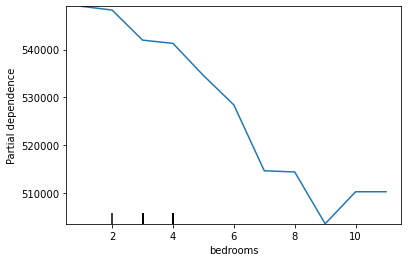

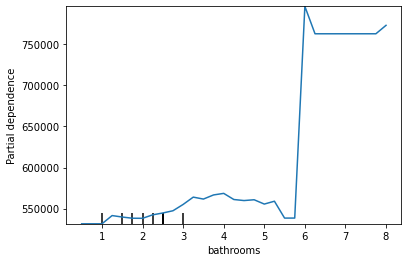

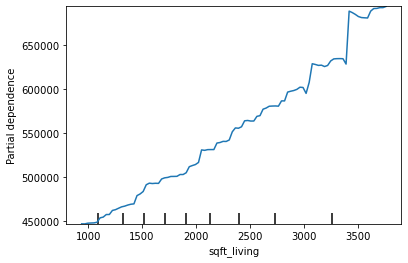

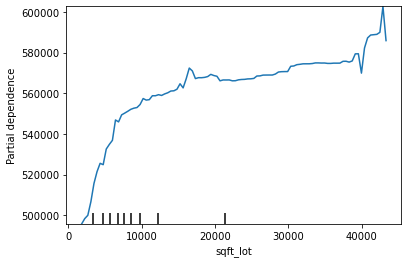

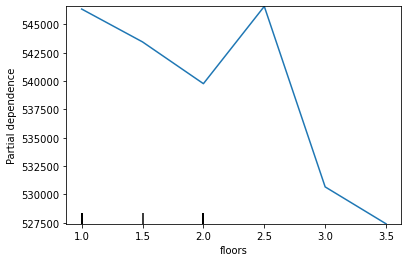

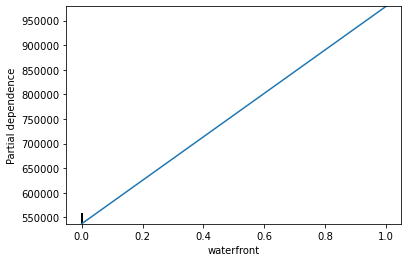

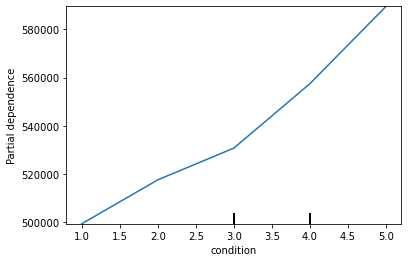

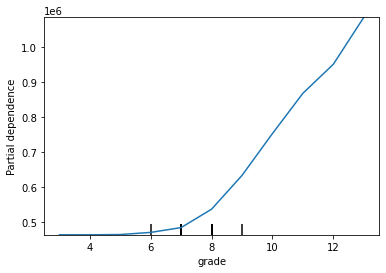

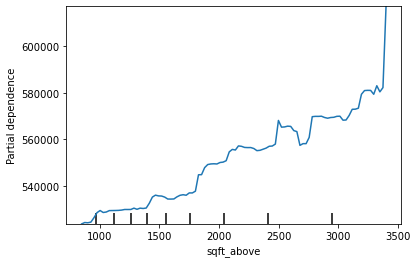

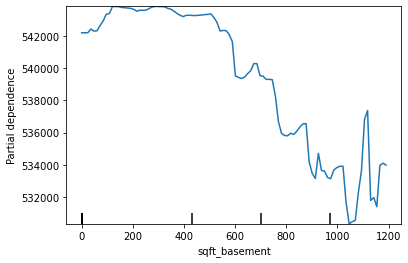

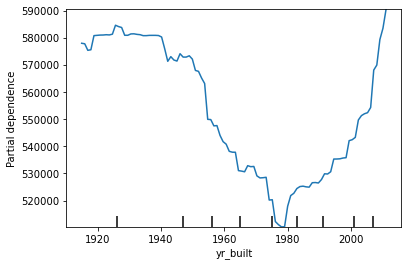

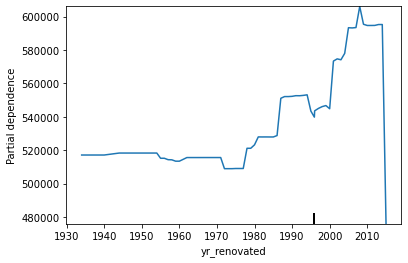

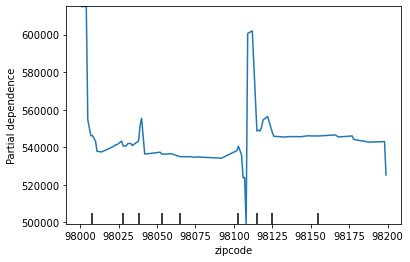

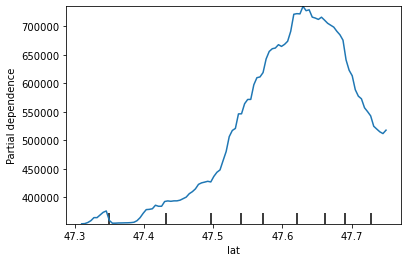

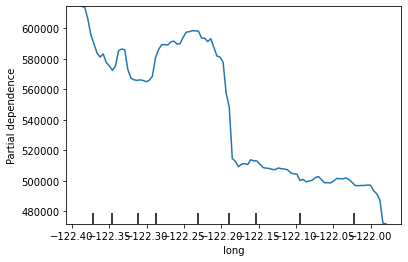

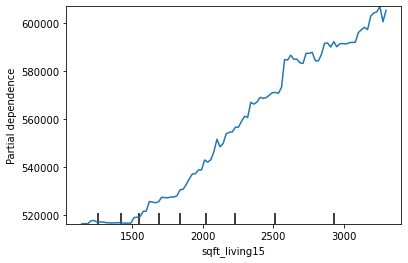

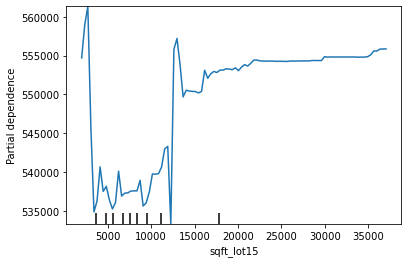

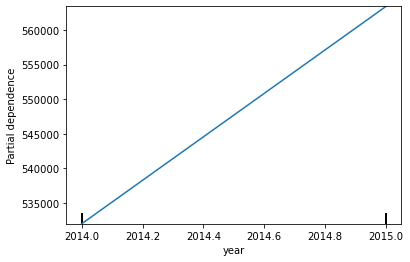

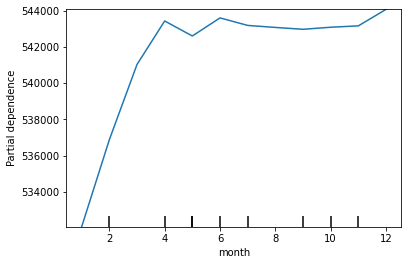

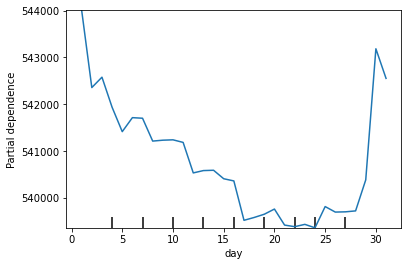

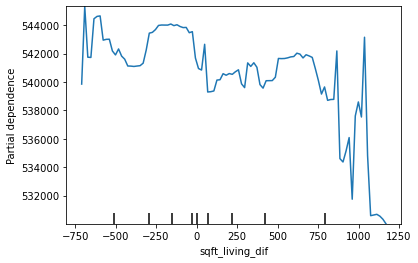

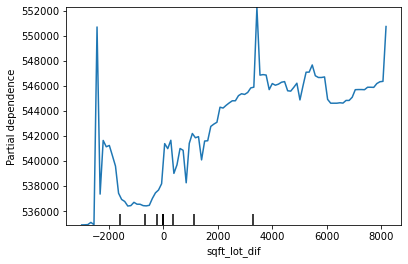

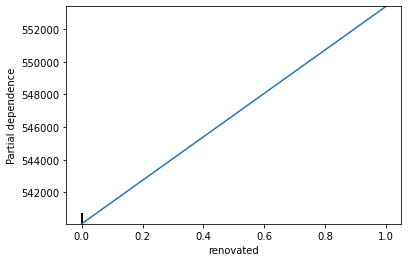

In [6]:
for column in X_train.columns:
    plot_partial_dependence(xg_model, clean_data,  [column])

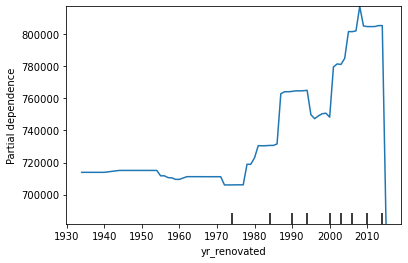

In [7]:
plot_partial_dependence(xg_model, clean_data[clean_data["renovated"]==1], ['yr_renovated'])

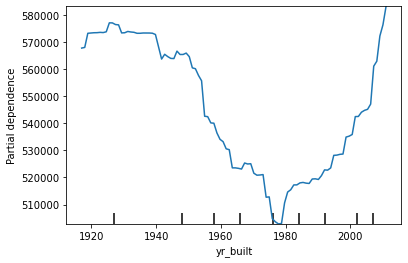

In [8]:
plot_partial_dependence(xg_model, clean_data[clean_data["renovated"]==0], ['yr_built'])

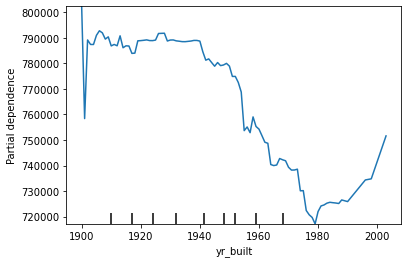

In [9]:
plot_partial_dependence(xg_model, clean_data[clean_data["renovated"]==1], ['yr_built'])

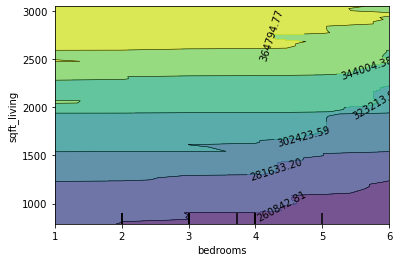

In [10]:
plot_partial_dependence(xg_model, clean_data[clean_data['zipcode'] == 98178], [('bedrooms', 'sqft_living')])

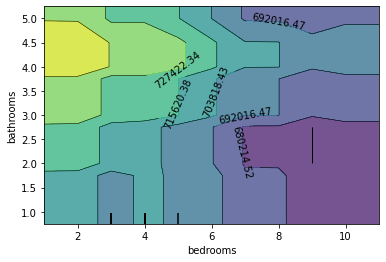

In [11]:
plot_partial_dependence(xg_model, 
                        clean_data[(clean_data['sqft_living'] < 3500) 
                                   & (clean_data['sqft_living'] > 2500)], 
                        [('bedrooms', 'bathrooms')])

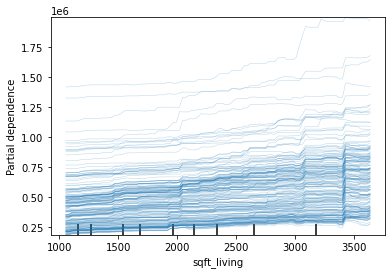

In [12]:
plot_partial_dependence(xg_model, clean_data[:200], ['sqft_living'], kind="individual")

## Evaluation

In [13]:
waterfront = (clean_data["waterfront"] == 1)
not_waterfront = (clean_data["waterfront"] == 0)
pred_data = xg_model.predict(clean_data)

In [14]:
high_appraisals = pred_data * .8> target_data
good_appraisals = (pred_data * .8 <= target_data) & (pred_data * 1.05 >= target_data)
low_appraisals = pred_data *1.05 < target_data

# Houses where 80% of appraised value exceeded sale price
# Risk of losing money if borrowers default on these loans
print("80% of Appraisal > Sale Price (High Appraisal): ",len(clean_data[high_appraisals]))

# Houses where 100% of appraised value fell short of sale price
# Difficult to find borrowers for these loans
print("Sale Price between 80% and 105% of appraisal (Good Appraisal): ", len(clean_data[good_appraisals]))

# Borrowers will walk away
print("105% of appraisal < Sale Price (Low Appraisal): ", len(clean_data[low_appraisals]))

80% of Appraisal > Sale Price (High Appraisal):  1128
Sale Price between 80% and 105% of appraisal (Good Appraisal):  14427
105% of appraisal < Sale Price (Low Appraisal):  6042


In [15]:
total_low_loans = sum(pred_data[low_appraisals]*.8) 
total_good_loans = sum(pred_data[good_appraisals]*.8)
total_high_loans = sum(pred_data[high_appraisals]*.8)
# Do not include low, we assume low appraisals scared off borrowers
total_loans = total_high_loans +  total_good_loans

print("Total missed loans (Low Appraisals): ", total_low_loans)
print("Total loans (Good Appraisals): ", total_good_loans)
print("Total loans (High Appraisals): ", total_high_loans)
print("Total loans (total): ", total_loans)
print()
      
print("Average missed loan (Low Appraisals): ", total_low_loans/ len(pred_data[low_appraisals]))
print("Average loan (Good Appraisals): ", total_good_loans/ len(pred_data[good_appraisals]))
print("Average loan (High Appraisals): ", total_high_loans/ len(pred_data[high_appraisals]))
print()
      
      
# Houses where 80% of appraised value exceeded sale price
# Risk of losing money if borrowers default on these loans
immediate_default_losses = pred_data[high_appraisals]*.8 - target_data[high_appraisals]
print("Total losses from High Appraisals (immediate default): ", sum(immediate_default_losses))
print("Losses from High Appraisals (immediate default) as % of total loans : ", sum(immediate_default_losses) * 100/ total_loans)
print("Average loss from High Appraisals (immediate default): ", sum(immediate_default_losses)/len(immediate_default_losses))
print()

Total missed loans (Low Appraisals):  2484016628.9492188
Total loans (Good Appraisals):  6456764666.5078125
Total loans (High Appraisals):  400871010.2578125
Total loans (total):  6857635676.765625

Average missed loan (Low Appraisals):  411124.89721105905
Average loan (Good Appraisals):  447547.28401662246
Average loan (High Appraisals):  355382.10129238694

Total losses from High Appraisals (immediate default):  42868671.2578125
Losses from High Appraisals (immediate default) as % of total loans :  0.6251231952005845
Average loss from High Appraisals (immediate default):  38004.14118600399



In [16]:
loan_values = {'Missed Loans': total_low_loans,
               'Good Loans': total_good_loans,
               'Risky Loans': total_high_loans}
number_appraisal = {'Low Appraisal': len(clean_data[low_appraisals]),
                    'Good Appraisal': len(clean_data[good_appraisals]),
                    'High Appraisal': len(clean_data[high_appraisals])
                   }
risk_loans = {'Total Loans': int(total_loans),
             'immediate default': int(sum(immediate_default_losses))}

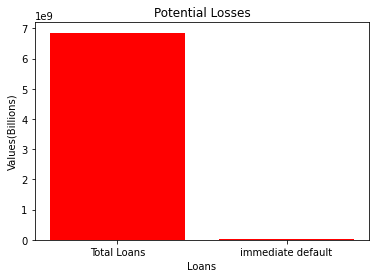

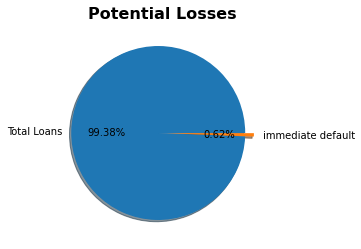

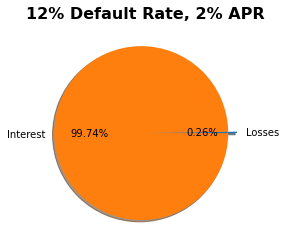

In [17]:
vis.bar_chart(risk_loans, "Loans", "Values(Billions)", "Potential Losses")

# Assume default rate of 50%, all defaults occur immediately.
scenario_1_default_rate  = .12
scenario_1_losses = immediate_default_losses * scenario_1_default_rate
# Assume 1% interest rate. 
# A 30 year fixed rate mortgage with a 2% APR would result in about 33% interest over the lifetime of the loan
scenario_1_interest = (total_loans * (1-scenario_1_default_rate)) * .33

scenario_1 = {
    "Losses": sum(scenario_1_losses),
    "Interest": scenario_1_interest,
}
vis.pie_chart(risk_loans, "Potential Losses")
vis.pie_chart(scenario_1, "12% Default Rate, 2% APR")

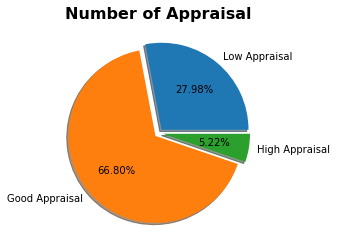

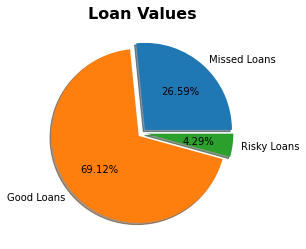

In [18]:
vis.pie_chart(number_appraisal, "Number of Appraisal")
vis.pie_chart(loan_values, "Loan Values")


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error = mean_squared_error(target_data, pred_data, squared=False)
mean_absolute_error = mean_absolute_error(target_data, pred_data)

In [20]:
mean_house_price = target_data.mean()

In [21]:
mean_price_error = {"mean_house_price": mean_house_price,
                    "mean_absolute_error": mean_absolute_error}
mean_price_error

{'mean_house_price': 540296.5735055795,
 'mean_absolute_error': 44852.386111207576}

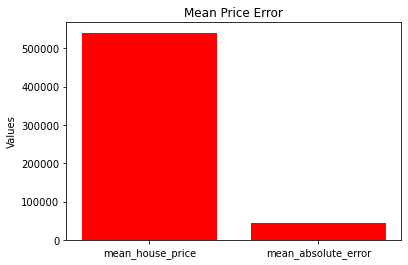

In [22]:
vis.bar_chart(mean_price_error, "", "Values", "Mean Price Error")

## Conclusions

The model is very good at predicting house prices in 2014-2015. Training on data outside this period will be necessary to help it understand larger trends in housing prices.
Using this model to appraise houses nearly guarantees interest made from loans will cover money lost to bad appraisals + default, even under very adverse assumptions (12% foreclosure rate, 2% APR).
We assumed the market remained stable during foreclosures; we did not analyze the case where a market crash depresses housing values simultaneously with default. That could increase losses significantly in a worst case scenario
This model could definitely generate a profit, but client should work with us to determine expected ROI using more realistic assumptions of default rate and APR to evaluate whether this model is more profitable than their existing process.

# Linear Model

## Linear Model Feature Engineering

These feature engineering steps did not improve the XGBoost or Random Forest models, but helped the Linear Regression model deal with non-linear correlation.

In [354]:
def split_linear_feature(df, column_name, cutoff):
    df[f"{column_name}_above_{cutoff}"] = (df[column_name] - cutoff).clip(lower=0.0)
    df[f"{column_name}_below_{cutoff}"] = (cutoff - df[column_name]).clip(lower=0.0)
    #df.drop(column_name, axis=1, inplace=True)
    
def add_linear_features(df):
    """These features are non-linear, but can be decomposed into several approximately linear pieces"""
    # Lead based paint banned in 1978 == local minimum in 1978
    split_linear_feature(df, "yr_built", 1978)
    split_linear_feature(df, "yr_renovated", 1978)
    # Latitude has a maximum near 47.64
    split_linear_feature(df, "lat", 47.64)



In [355]:
X_linear = clean_data.copy()
X_train_linear = X_train.copy()
X_test_linear = X_test.copy()

add_linear_features(X_linear)
add_linear_features(X_train_linear)
add_linear_features(X_test_linear)
col_names = X_train_linear.columns

In [356]:
print(col_names)
X_train_linear

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'year', 'month', 'day', 'sqft_living_dif', 'sqft_lot_dif',
       'renovated', 'yr_built_above_1978', 'yr_built_below_1978',
       'yr_renovated_above_1978', 'yr_renovated_below_1978', 'lat_above_47.64',
       'lat_below_47.64'],
      dtype='object')


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,...,day,sqft_living_dif,sqft_lot_dif,renovated,yr_built_above_1978,yr_built_below_1978,yr_renovated_above_1978,yr_renovated_below_1978,lat_above_47.64,lat_below_47.64
8125,5,2.75,1340,11583,1.0,0.0,3,7,1190,150.0,...,23,-610,1069,0,0,16,17.928763,0.0,0.0690,0.0000
15216,3,2.50,2840,7500,2.0,0.0,3,11,2840,0.0,...,29,260,1582,0,19,0,17.928763,0.0,0.0649,0.0000
14302,3,1.75,1230,8250,1.0,0.0,3,7,1230,0.0,...,25,-20,0,0,0,12,17.928763,0.0,0.0000,0.1874
9487,3,2.50,1960,6997,2.0,0.0,3,7,1960,0.0,...,9,-360,1819,0,28,0,17.928763,0.0,0.0000,0.0985
1732,1,1.00,680,1638,1.0,0.0,1,6,680,0.0,...,2,-330,-1983,1,0,68,14.000000,0.0,0.0000,0.0568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5520,3,1.75,1660,10440,1.0,0.0,3,7,1040,620.0,...,31,420,60,0,0,0,17.928763,0.0,0.0000,0.1952
3046,3,2.50,2200,4544,2.0,0.0,3,8,2200,0.0,...,13,-200,-887,0,22,0,17.928763,0.0,0.0000,0.1081
20463,2,1.50,770,850,2.0,0.0,3,7,770,0.0,...,24,-580,-65,0,28,0,17.928763,0.0,0.0000,0.0756
18638,5,1.75,2000,10246,1.0,0.0,3,7,1200,800.0,...,27,-340,1216,0,0,25,17.928763,0.0,0.0000,0.1316


## Linear Models

Using all 26 features, best R^2 is .758. This is not great compared to non-linear models, and still hard to interpret.

Using only 10 features, we can still achieve .752 and have a model which is much easier to interpret

In [357]:
ols_linear = linear_model.LinearRegression()
score = prep.model(ols_linear, X_train_linear, X_test_linear, y_train, y_test)
coef = ols_linear.coef_
feature_coef = dict(zip(col_names[abs(coef) > 0], coef[abs(coef)>0]))
score, feature_coef

(0.7577900867470017,
 {'bedrooms': -36601.63256494137,
  'bathrooms': 34053.89058276412,
  'sqft_living': 87.28498418563895,
  'sqft_lot': 0.14629874880656213,
  'floors': -42954.821379822206,
  'waterfront': 699810.5931809183,
  'condition': 37072.111878843396,
  'grade': 79481.03743824975,
  'sqft_above': 90.0151847363395,
  'sqft_basement': 41.66187601780398,
  'yr_built': -795.7975995748966,
  'yr_renovated': 2580.901329531127,
  'zipcode': -761.80078082056,
  'lat': -162850.5235495154,
  'long': -356981.52870175004,
  'sqft_living15': 58.98595586887296,
  'sqft_lot15': 0.0727874413118177,
  'year': 42278.40300290168,
  'month': 1382.7784651690085,
  'day': -214.79417086114586,
  'sqft_living_dif': 28.29902840449129,
  'sqft_lot_dif': 0.0735109730351915,
  'renovated': 69474.91404386089,
  'yr_built_above_1978': 856.0389191862154,
  'yr_built_below_1978': 1651.8365187563247,
  'yr_renovated_above_1978': 973.8619699123614,
  'yr_renovated_below_1978': -1607.039359617612,
  'lat_abov

In [358]:
omp_linear = linear_model.OrthogonalMatchingPursuitCV(max_iter=10)
score = prep.model(omp_linear, X_train_linear, X_test_linear, y_train, y_test)
coef = omp_linear.coef_
feature_coef = dict(zip(col_names[abs(coef) > 0], coef[abs(coef)>0]))
score, feature_coef

(0.7521661471562221,
 {'bedrooms': -34866.65987492435,
  'sqft_living': 215.31569857181765,
  'waterfront': 708015.0280842192,
  'condition': 32483.00887981343,
  'grade': 89384.9660369403,
  'zipcode': -817.5395779921682,
  'long': -293409.4482210511,
  'yr_built_below_1978': 2594.158534675457,
  'lat_above_47.64': -1605208.4576343102,
  'lat_below_47.64': -1163943.803533948})

In [359]:
X_top_10_features = X_linear.copy()
columns_to_drop = [c for c in col_names if c not in feature_coef.keys()]

for c in columns_to_drop:
    X_top_10_features.drop(c, axis=1, inplace=True)

X_top_10_features

,bedrooms,sqft_living,waterfront,condition,grade,zipcode,long,yr_built_below_1978,lat_above_47.64,lat_below_47.64
0,3,1180,0.0,3,7,98178,-122.257,23,0.0000,0.1288
1,3,2570,0.0,3,7,98125,-122.319,27,0.0810,0.0000
2,2,770,0.0,3,6,98028,-122.233,45,0.0979,0.0000
3,4,1960,0.0,5,7,98136,-122.393,13,0.0000,0.1192
4,3,1680,0.0,3,8,98074,-122.045,0,0.0000,0.0232
...,...,...,...,...,...,...,...,...,...,...
21592,3,1530,0.0,3,8,98103,-122.346,0,0.0593,0.0000
21593,4,2310,0.0,3,8,98146,-122.362,0,0.0000,0.1293
21594,2,1020,0.0,3,7,98144,-122.299,0,0.0000,0.0456
21595,3,1600,0.0,3,8,98027,-122.069,0,0.0000,0.1055


## Multicollinearity

HeatMap and features correlated > .75 show low multicollinearity among selected features.

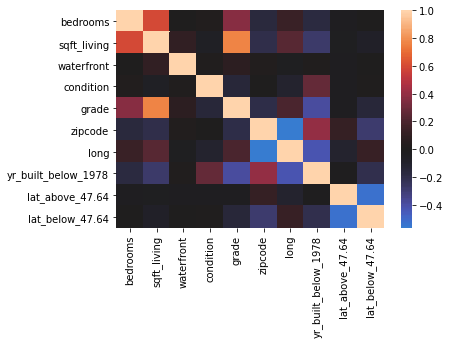

In [360]:
import seaborn as sns
sns.heatmap(X_top_10_features.corr(), center=0);

In [361]:
def get_correlated_features(data_pred):
    """From Multi-collinearity lesson"""
    # save absolute value of correlation matrix as a data frame
    # converts all values to absolute value
    # stacks the row:column pairs into a multindex
    # reset the index to set the multindex to seperate columns
    # sort values. 0 is the column automatically generated by the stacking

    df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    # zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    # set index to pairs
    df.set_index(['pairs'], inplace = True)

    #d rop level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    # rename correlation column as cc rather than 0
    df.columns = ['cc']

    # drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
    # for the sake of exercise, kept it in.
    df.drop_duplicates(inplace=True)
    
    return df[(df.cc>.75) & (df.cc <1)]

In [362]:
correlated_features = get_correlated_features(X_top_10_features)
correlated_features

,cc
pairs,
"(grade, sqft_living)",0.762779


## Residual Analysis

QQ, KDE, and Jarque-Bera all show that the residuals are not normal, and assumptions about the linear regression have been violated.

In [363]:
residuals = (y_test - omp_linear.predict(X_test_linear))
residuals

array([ 35813.9394173 , 364907.18423601, 220187.00271644, ...,
        83453.60498668,  39874.25430643, -54299.79752758])

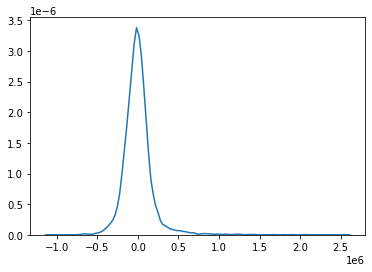

In [364]:
sns.kdeplot(residuals)

<ipython-input-365-ab36a0766cd8>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


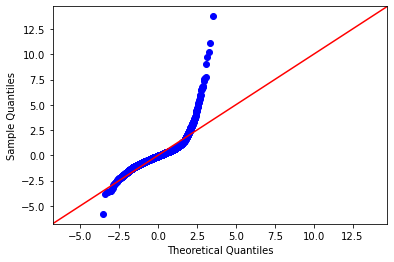

In [365]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [366]:
import statsmodels.stats.api as sms
# JB test for TV
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(residuals)
list(zip(name, test))

[('Jarque-Bera', 115820.56330980973),
 ('Prob', 0.0),
 ('Skew', 2.6578047381912597),
 ('Kurtosis', 25.056798386196085)]

In [367]:
data = X_top_10_features.copy()
data['target'] = target_data.copy()

In [368]:
outcome = 'target'

mapper = lambda x: x.replace('.', '')
for col in X_top_10_features.columns:
    if '.' in col:
        data.rename(mapper, axis=1, inplace=True)
x_cols = [c.replace('.','') for c in X_top_10_features.columns]
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     5731.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:03:36   Log-Likelihood:            -2.9340e+05
No. Observations:               21597   AIC:                         5.868e+05
Df Residuals:                   21586   BIC:                         5.869e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             4.13e+07   2.72e+06     15.163      0.000     3.6e+07    4.66e+07
bedrooms            -3.492e+04   1838.083    -18.999      0.000   -3.85e+04   -3.13e+04
sqft_living           211.5299      2.636     80.243      0.000     206.363     216.697
waterfront            8.06e+05   1.62e+04     49.878      0.000    7.74e+05    8.38e+05
condition            3.298e+04   2122.874     15.536      0.000    2.88e+04    3.71e+04
grade                8.985e+04   1912.337     46.983      0.000    8.61e+04    9.36e+04
zipcode              -793.6451     31.510    -25.187      0.000    -855.408    -731.883
long                -2.951e+05   1.19e+04    -24.777      0.000   -3.18e+05   -2.72e+05
yr_built_below_1978  2490.5881     81.406     30.595      0.000    2331.026    2650.150
lat_above_4764      -1.627e+06   4.29e+04    -37.935      0.000   -1.71e+06   -1.54e+06
lat_below_4764      -1.169e+06    1.5e+04    -78.003      0.000    -1.2e+06   -1.14e+06
==============================================================================
Omnibus:                    19647.130   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2364026.809
Skew:                           3.940   Prob(JB):                         0.00
Kurtosis:                      53.646   Cond. No.                     2.04e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Interpretation of Linear Model

## Summary
My final linear model (Orthogonal Matching Pursuit) is worse than most non-linear models I tried at predicting prices, but easy to interpret and explain.

It only uses 10 features with low collinearity, and the R^2 of .752 is still very close to Ordinary Least Squares using all 26 provided and engineered features (.758). The OLS version is much harder to understand, and also much worse than non-linear models.

The features used and their rounded coefficients are 

```
waterfront:          708,015
grade:               89,385
condition:           32,483
yr_built_below_1978: 2,594
sqft_living:         215
zipcode:            -818
bedrooms:           -34,867
long:               -293,409
lat_below_47.64:    -1,163,944
lat_above_47.64:    -1,605,208
```

Five(!) of the top 10 features are about lot location (waterfront, zipcode, long, lat_below_47.64, lat_above_47.64). Real estate really is about location, location, location. Waterfront is a huge `$700,000` boost in value.

The yr_built is important for homes built before 1978 but did not make the cut for newer homes, and neither did any renovation metrics. The only variables that a homeowner can control that our model selected were bedrooms, condition, grade, and sqft_living. Fewer bedrooms is actually better, but you want more of everything else. Each step in grade is worth `$90,000`, condition is `$30,000`, and each additional sqft is `$215`.

Don't take any of this analysis too seriously however, analysis shows that key assumptions have been violated and Linear Regression is not a great fit for this dataset.




## Multicollinearity of Features 

In the 10 features selected by the OrthogonalMatchingPursuit algorithm https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html, multicollinearity is very low. Only the (grade, sqft_living) features had a correlation barely above .75	(0.762779). This did not seem problematic enough to correct for. The Heatmap shows the same information (only diagonals seem light pink).

Both OMPCV (Orthogonal Matching Pursuit) and RFECV (Recursive Feature Elimination Cross Validation) which I found looking at sklearn API were good at training linear models to give interpretable results without much multicollinearity.

OMPCV gave slightly better results than RFECV, but was also much faster for me to train, which helped as I experimented with feature engineering.

## Regression Analysis
### Summary (OMP Model)
The data seems to violate the assumptions for Linear Regression Models. This is not surprising since the best Linear Model is a lot worse than other models (even before optimization).

### Residual Analysis (OMP Model)
The residual analysis using both the KDE plot and the QQ plot shows the residuals are not normally distributed. The residual distribution is skewed and light tailed.

### Feature Analysis (OMP Model)
Many features are not normally distributed, but transforming them using logtransforms did not improve model performance.

### Jarque-Bera Test (statsmodel OLS Model)
I wasn't sure how to do the Jarque-Bera test directly on an sklearn model, so I trained a new model using statsmodel Ordinary Least Squares using only the 10 features selected by the OMP model. The coefficients are close (e.g., -817.54 vs -793.65 for Zip Code). The statsmodel OLS model has an R^2 that is lower, but that shouldn't change the final analysis. 

Doing the Jarque-Bera test on the OLS model shows results that confirm the residual analysis: Key Assumptions have been violated and Linear Regression is probably not the right choice for this dataset.